In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import glob
%matplotlib inline

In [16]:
# Create and test the video sequence for the Car4 dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\*.jpg'):
    
    #Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Car.avi',fourcc,5.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

In [17]:
# Create and test the video sequence for the Bolt dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg'):
    
    # Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Bolt.avi',fourcc,5.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

In [17]:
# Create and test the video sequence for the BabyDragon dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\*.jpg'):
    
    # Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('DragonBaby.avi',fourcc,20.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

## Implementation of the Lucas Kanade metod for Affine Warp

Warp the image $I$ to obtain $I(W[x,y];P)$

Compute the error image $T(x)-I(W[x,y];P)$

Warp the Gradient ${\nabla{I}}$ with $(W[x,y];P)$

Evaluate $\frac{\partial W}{\partial P}$ at $([x,y];P)$

Compute Steepest descent images ${\nabla{I}}\frac{\partial W}{\partial P}$

Compute the Hessian Matrix $\sum{({\nabla{I}}\frac{\partial W}{\partial P})}^{T}{{\nabla{I}}\frac{\partial W}{\partial P}}$

Compute $\sum{({\nabla{I}}\frac{\partial W}{\partial P})}{(T(x)-I(W[x,y];P))}$

Compute ${\Delta P}$

$P{\leftarrow}P+{\Delta P}$

Keep Iterating till the magnitude of ${\Delta P}$ is negligible

And also ${\Delta P} = {({A}^{T}{A}})^{-1}{A^{T}}{b}$

Here ${{A}^{T}{A}}$ is the Hessian Matrix that has been computed above and $A$ is the steepest descent image and $b$ is basicallty the error image that has been computed in step 2

Affine Transform is given as ${\begin{bmatrix} 1+{p_1} & {p_3} & {p_5}\\ {p_2} & {1+{p_4}} & {p_{6}}\\0&0&1\\\end{bmatrix}}$

In [71]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
import glob
%matplotlib inline

# Get a grayscale image to input in the Lucas Kanade 
def get_grayscale_image(image):
    
    """
    Inputs:
    path_to_frame: The path to the frame that needs to be converted to a grayscale image: dtype=string
    
    """
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(grayscale, (3, 3),0)  
    return grayscale

# Reference: CMU Graduate computer Vision Course
def crop_warped(image,rect):
    
    """
    Inputs:
    image: The warped image after performing an affine transformation
    rect: The upleft and the truth bounding box
    
    """
    #warped = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    warped = image[rect[1]:rect[3], rect[0]:rect[2]]
    return warped
    
def LucasKanadeAffine(image,template,rect,p,threshold, iterations):
    
    """
    Inputs:
    
    image: The input gray scale image
    template: The template image
    rect: The top left coordinates and the bottom right coordinates of the rectangle format--> [x1,y1,x2,y2]
    threshold: The threshold that has been set to terminate the iterations as soon as delta p value approaches the threshold value
    parameters: The initial parameters of the affine warp
    iterations: Number of times the algorithm needs to run
    
    Returns:
    p: Paramters of the affine warp matrix
    Upper left bounding bax coordinates
    Downright bounding box coordinates
    """
    # Crop the region of interest from the template frame
    template = crop_warped(template,rect)
    
    # Parameters of the affine matrix
    #p = np.array([parameters]).reshape(-1,1)
    
    # Threshold for convergence
    thresh = threshold
    
    # Initial Affine Matrix
    #affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]])
    
    # affine matrix
    affine_matrix = np.array([[1 + p[0][0], p[2][0], p[4][0]], [p[1][0], 1 + p[3][0], p[5][0]]], dtype = np.float32)
    
    #I = affine_matrix
    # Compute the image gradient in the x direction
    sobelx = cv2.Sobel(image, cv2.CV_64F, dx = 1, dy = 0, ksize = 7)
    
    # Compute the image gradient in the y direction
    sobely = cv2.Sobel(image, cv2.CV_64F, dx = 0, dy = 1, ksize = 7)
    
    for iteration in range(iterations):
        
        # Warp the input image
        warped_image = cv2.warpAffine(image, affine_matrix, (0, 0), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)
        
        # Compute the error image
        error_image = template - crop_warped(warped_image, rect)
        
        # Compute the warped gradient in the x direction
        sobel_x_warped = cv2.warpAffine(sobelx, affine_matrix, (0,0), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)
        
        # Crop the Region of interest in our image gradient
        sobel_x_cropped = crop_warped(sobel_x_warped, rect)
        
        # Compute the warped gradient in the y direction
        sobel_y_warped = cv2.warpAffine(sobely, affine_matrix, (0,0), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
        
        # Crop the Region of interest in our image gradient
        sobel_y_cropped = crop_warped(sobel_y_warped, rect)
        
        # Flatten out the warped gradients
        sobel_x_cropped = sobel_x_cropped.reshape(-1,1)
        sobel_y_cropped = sobel_y_cropped.reshape(-1,1)
        
        # Warp the image gradient with the warping function to produce an mx2 matrix
        # Horizontally stack the derivatives
        gradient_image_warped = np.hstack((sobel_x_cropped,sobel_y_cropped))
        
        # Evaluate the Jacobian and the steepest descent 
        count = 0
        steepest_descent = []
        for y in range(rect[1],rect[3]):
            for x in range(rect[0],rect[2]):
                
                Jacobian = [x*sobel_x_cropped[count][0], x*sobel_y_cropped[count][0], y*sobel_x_cropped[count][0], y*sobel_y_cropped[count][0], sobel_x_cropped[count][0], sobel_y_cropped[count][0]]
                steepest_descent.append(Jacobian)
                count = count + 1
        steepest_descent = np.array(steepest_descent)
        
        # Calculate the Hessian and inverse hessian from the steepest descent
        sd_params_update = np.dot(steepest_descent.T,error_image.reshape(-1,1))
        hessian = np.dot(steepest_descent.T,steepest_descent)
        hessian_inverse = np.linalg.pinv(hessian)
        
        # Update delta p using solution for least squares
        delta_p = np.dot(hessian_inverse, sd_params_update)
        
        # Update the parameters p
        p = np.reshape(p, (6, 1))
        p = p + delta_p
        #print(f'After Iteration: {iterations} Value of p: {p}')
        
        # Update the affine matrix with the newly generated parameters
        #affine_matrix = p.reshape(2,3) + I
        
        # Convergence test
        if np.linalg.norm(delta_p) <= thresh:
            break
            
    # Updated affine matrix
    affine_matrix = np.array([[(1 + p[0][0]), (p[2][0]), (p[4][0])], [(p[1][0]), (1 + p[3][0]), (p[5][0])]], dtype = np.float32)
    top_left_coordinates = np.array([[rect[0]],[rect[1]],[1]])
    bottom_right_coordinates = np.array([[rect[2]], [rect[3]], [1]])
    updated_top_left_coordinates = np.dot(affine_matrix, top_left_coordinates)
    updated_bottom_right_coordinates = np.dot(affine_matrix, bottom_right_coordinates)
    
    print(f'top_left: {updated_top_left_coordinates} \tbottom_right:{updated_bottom_right_coordinates}')
    return p, updated_top_left_coordinates, updated_bottom_right_coordinates


In [72]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,303,139])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

p = np.array([[0, 0, 0, 0, 0, 0]]).T

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Run the Lucas Kanade Algorithm
    p, top_left_coordinates, bottom_right_coordinates = LucasKanadeAffine(grayscale_image,grayscale_template,rect_bolt, p,threshold = 0.001, iterations = 35)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 1)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Bolt.avi',fourcc,20.0, (480, 270))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[269.]
 [ 75.]] 	bottom_right:[[303.]
 [139.]]
top_left: [[268.91669621]
 [ 74.92242302]] 	bottom_right:[[303.09304054]
 [139.19495073]]
top_left: [[268.80534913]
 [ 74.85522616]] 	bottom_right:[[303.20878332]
 [139.37317646]]
top_left: [[268.6167293 ]
 [ 74.74172207]] 	bottom_right:[[303.40128154]
 [139.5408401 ]]
top_left: [[268.42490114]
 [ 74.61887602]] 	bottom_right:[[303.59428726]
 [139.69884143]]
top_left: [[268.4074647 ]
 [ 74.53653202]] 	bottom_right:[[303.68837632]
 [139.83435221]]
top_left: [[268.37194537]
 [ 74.45513551]] 	bottom_right:[[303.75899284]
 [139.92218015]]
top_left: [[268.27887746]
 [ 74.37382803]] 	bottom_right:[[303.99035402]
 [140.0723259 ]]
top_left: [[268.33172193]
 [ 74.32008871]] 	bottom_right:[[304.03726247]
 [140.16884401]]
top_left: [[268.41536615]
 [ 74.26060241]] 	bottom_right:[[304.07436249]
 [140.26725942]]
top_left: [[268.3899524 ]
 [ 74.20403398]] 	bottom_right:[[304.2607337 ]
 [140.40686683]]
top_left: [[268.26361437]
 [ 74.19179228]]

top_left: [[260.55831573]
 [ 69.75378582]] 	bottom_right:[[317.89415238]
 [148.99828878]]
top_left: [[260.44786976]
 [ 69.71026906]] 	bottom_right:[[318.29332349]
 [149.1477903 ]]
top_left: [[260.35555895]
 [ 69.68144282]] 	bottom_right:[[318.62630375]
 [149.257796  ]]
top_left: [[260.28509284]
 [ 69.68316384]] 	bottom_right:[[318.8098743 ]
 [149.28813583]]
top_left: [[260.17477451]
 [ 69.67900166]] 	bottom_right:[[319.06187283]
 [149.35677841]]
top_left: [[260.07942273]
 [ 69.64114523]] 	bottom_right:[[319.30031253]
 [149.43565806]]
top_left: [[259.98605297]
 [ 69.58375975]] 	bottom_right:[[319.48552916]
 [149.54677152]]
top_left: [[259.92961677]
 [ 69.53510927]] 	bottom_right:[[319.60209235]
 [149.6174515 ]]
top_left: [[259.88016271]
 [ 69.47478788]] 	bottom_right:[[319.7045927 ]
 [149.71070557]]
top_left: [[259.81249636]
 [ 69.39719129]] 	bottom_right:[[319.81644791]
 [149.79159673]]
top_left: [[259.72220471]
 [ 69.32057229]] 	bottom_right:[[319.95569327]
 [149.88730499]]
top_left: 

top_left: [[246.75863628]
 [ 64.82370716]] 	bottom_right:[[322.93461852]
 [152.67704147]]
top_left: [[246.11023861]
 [ 64.67808609]] 	bottom_right:[[322.88784081]
 [152.64638473]]
top_left: [[245.5454759 ]
 [ 64.53937823]] 	bottom_right:[[322.78838629]
 [152.61506218]]
top_left: [[244.79107389]
 [ 64.35012043]] 	bottom_right:[[322.89280662]
 [152.62004292]]
top_left: [[244.31510992]
 [ 64.25910172]] 	bottom_right:[[322.99335738]
 [152.6035209 ]]
top_left: [[243.58214512]
 [ 64.08777729]] 	bottom_right:[[323.25312939]
 [152.64985296]]
top_left: [[243.02566179]
 [ 63.95289728]] 	bottom_right:[[323.32575163]
 [152.66083542]]
top_left: [[242.43435796]
 [ 63.79603808]] 	bottom_right:[[323.28023131]
 [152.65992869]]
top_left: [[241.96082683]
 [ 63.73407479]] 	bottom_right:[[323.34889336]
 [152.64276074]]
top_left: [[241.776343  ]
 [ 63.69232245]] 	bottom_right:[[323.3615929 ]
 [152.65434907]]
top_left: [[241.59317786]
 [ 63.62686305]] 	bottom_right:[[323.30005461]
 [152.68330432]]
top_left: 

top_left: [[232.02210083]
 [ 55.32854564]] 	bottom_right:[[326.65649261]
 [155.59530531]]
top_left: [[232.17900951]
 [ 55.3103871 ]] 	bottom_right:[[326.35543735]
 [155.55471268]]
top_left: [[232.37646537]
 [ 55.25633918]] 	bottom_right:[[325.92162424]
 [155.54405303]]
top_left: [[232.34382154]
 [ 55.14740314]] 	bottom_right:[[326.04249765]
 [155.5636857 ]]
top_left: [[232.28655455]
 [ 54.91299497]] 	bottom_right:[[326.09202239]
 [155.60092564]]
top_left: [[232.3661337 ]
 [ 54.56705837]] 	bottom_right:[[326.52964354]
 [155.71159436]]
top_left: [[232.50422596]
 [ 54.16336668]] 	bottom_right:[[326.40468621]
 [155.86848509]]
top_left: [[232.56978587]
 [ 53.85616282]] 	bottom_right:[[326.174202  ]
 [156.08207116]]
top_left: [[232.64833281]
 [ 53.58632697]] 	bottom_right:[[326.15678237]
 [156.30941348]]
top_left: [[232.70452558]
 [ 53.351136  ]] 	bottom_right:[[326.17914091]
 [156.50968274]]
top_left: [[232.56498158]
 [ 53.12567683]] 	bottom_right:[[326.3941077 ]
 [156.70530938]]
top_left: 

64

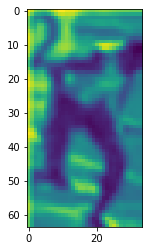

In [79]:
frame1 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\0001.jpg',0)
frame2 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\0001.jpg',0)
frame3 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\0001.jpg',0)

rect_car = [70,51,107+70,87+51]
rect_bolt = np.array([269,75,34+269,64+75])
rect_baby = np.array([160,83,56+160,65+83])

frame1_copy = frame1.copy()
frame1_copy = cv2.rectangle(frame1_copy,(rect_bolt[0],rect_bolt[1]),(rect_bolt[2],rect_bolt[3]),color = (255,0,0),thickness = 1)
template = frame1_copy[rect_bolt[1]:rect_bolt[3],rect_bolt[0]:rect_bolt[2]]
template = cv2.GaussianBlur(template, (3, 3),0)
cv2.imshow('frame 2', frame1_copy)
plt.imshow(template)
frame1.shape
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
template.shape[0]

In [21]:
frame1 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\0001.jpg',0)
frame1.shape

(270, 480)

In [119]:
# Get a grayscale image to input in the Lucas Kanade 
def get_grayscale_image(image):
    
    """
    Inputs:
    path_to_frame: The path to the frame that needs to be converted to a grayscale image: dtype=string
    
    """
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #grayscale = cv2.GaussianBlur(grayscale, (5, 5),5)  
    return grayscale

# Reference: CMU Graduate computer Vision Course
def crop_warped(image,rect):
    
    """
    Inputs:
    image: The warped image after performing an affine transformation
    rect: The upleft and the truth bounding box
    
    """
    #warped = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    warped = image[rect[1]:rect[3], rect[0]:rect[2]]
    return warped

# update the grayscale image, that is, normalize the pixel values with template image
def update_grayscale_image(template_image, image):
    """
    Inputs:
    
    template_image: the template grayscale image whose ROI is given to us
    image: the current grayscale frame 
    
    Outputs:
    
    image: the normalized current grayscale frame
    """
    
    # get the mean of the template image and current frame and normalize
    template_mean = np.mean(template_image)
    mean = np.mean(image)
    image = (image * (template_mean / mean)).astype(float)
    
    # return the normalized current grayscale frame
    return image

# The inverse Compositional Lucas Kanade Algorithm
def LucasKanadeInverseCompositional(template, image, rect, affine_matrix, threshold, iterations):
    
    """
    Inputs:
    
    image: The input gray scale image
    template: The template image
    rect: The top left coordinates and the bottom right coordinates of the rectangle format--> [x1,y1,x2,y2]
    threshold: The threshold that has been set to terminate the iterations as soon as delta p value approaches the threshold value
    parameters: The initial parameters of the affine warp
    iterations: Number of times the algorithm needs to run
    
    Returns:
    
    p: Paramters of the affine warp matrix
    Upper left bounding bax coordinates
    Downright bounding box coordinates
    
    """
    # Threshold for convergence
    thresh = threshold
    
    # Crop the Region of interest in our template
    template = crop_warped(template, rect)
    
    # Evaluation of the template gradient 
    # Compute the image gradient in the x direction
    sobelx_template = cv2.Sobel(template, cv2.CV_64F, dx = 1, dy = 0, ksize = 5)
        
    # Compute the image gradient in the y direction
    sobely_template = cv2.Sobel(template, cv2.CV_64F, dx = 0, dy = 1, ksize = 5)
    
    # Horizontally stack the obtained Template gradients
    # Flatten out the warped gradients
    sobelx_template = sobelx_template.reshape(-1,1)
    sobely_template = sobely_template.reshape(-1,1)
    
    # Template Gradient
    template_gradient = np.hstack((sobelx_template,sobely_template))
    
    I = affine_matrix
    
    # Evaluate the Jacobian and the steepest descent 
    count = 0
    steepest_descent = []
    for y in range(rect[1],rect[3]):
        for x in range(rect[0],rect[2]):
                
            Jacobian = [x*sobelx_template[count][0], x*sobely_template[count][0], y*sobelx_template[count][0], y*sobely_template[count][0], sobelx_template[count][0], sobely_template[count][0]]
            steepest_descent.append(Jacobian)
            count = count + 1
    steepest_descent = np.array(steepest_descent)
    
    # Evaluate the Hessian Matrix
    hessian = np.matmul(steepest_descent.T,steepest_descent)
    
    for iterations in range(iterations):
        
        # Warp the Input Image
        warped_image = cv2.warpAffine(image, affine_matrix, (0, 0), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
        
        # Compute the error image
        error_image = crop_warped(warped_image,rect) - template
        
        # Update the steepest descent parameters
        sd_params_update = np.matmul(steepest_descent.T, error_image.reshape(-1,1))
        
        #Compute delta p
        delta_p = np.matmul(np.linalg.pinv(hessian),sd_params_update)
        
        #Compute the updated Warp matrix
        affine_warp_delta_p = np.vstack([delta_p.reshape(2,3) + I,[0,0,1]])
        updated_warp_matrix = np.matmul(affine_matrix, np.linalg.inv(affine_warp_delta_p))
        
        # Convergence test
        if np.linalg.norm(delta_p) <= thresh:
            break
    top_left_coordinates = np.array([[rect[0]],[rect[1]],[1]])
    bottom_right_coordinates = np.array([[rect[2]], [rect[3]], [1]])
    updated_top_left_coordinates = np.matmul(updated_warp_matrix, top_left_coordinates)
    updated_bottom_right_coordinates = np.matmul(updated_warp_matrix, bottom_right_coordinates)
    
    print(f'top_left: {updated_top_left_coordinates} \tbottom_right:{updated_bottom_right_coordinates}')
    return updated_warp_matrix, updated_top_left_coordinates, updated_bottom_right_coordinates

In [ ]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,303,139])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

# affine matrix
affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]], dtype = np.float32)

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Update Gray scale image
    grayscale_image = update_grayscale_image(grayscale_template, grayscale_image)
    # Run the Lucas Kanade Algorithm
    affine_matrix, top_left_coordinates, bottom_right_coordinates = LucasKanadeInverseCompositional(grayscale_template,grayscale_image,rect_bolt, affine_matrix, threshold = 0.001, iterations = 23)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 1)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Bolt.avi',fourcc,20.0, (480, 270))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[269.]
 [ 75.]] 	bottom_right:[[303.]
 [139.]]
top_left: [[268.90134125]
 [ 82.79920721]] 	bottom_right:[[302.88191508]
 [153.41591106]]
top_left: [[268.91992232]
 [ 81.80950793]] 	bottom_right:[[302.91783464]
 [151.6550765 ]]
top_left: [[268.91760161]
 [ 80.42844539]] 	bottom_right:[[302.90879891]
 [149.07091713]]
top_left: [[268.9937962 ]
 [ 75.03118593]] 	bottom_right:[[302.99101824]
 [139.04872646]]
top_left: [[269.0209553 ]
 [ 74.31153499]] 	bottom_right:[[303.03456309]
 [137.79334821]]
top_left: [[269.05468416]
 [ 70.55711914]] 	bottom_right:[[303.06660892]
 [130.80483637]]
top_left: [[269.08891671]
 [ 69.89550519]] 	bottom_right:[[303.1097727 ]
 [129.57970816]]
top_left: [[269.05088971]
 [ 70.24027642]] 	bottom_right:[[303.05679187]
 [130.18259945]]
top_left: [[269.07770973]
 [ 69.07731946]] 	bottom_right:[[303.09244094]
 [128.05130455]]
top_left: [[269.03882599]
 [ 70.95049358]] 	bottom_right:[[303.04300206]
 [131.49798678]]
top_left: [[269.01373538]
 [ 73.30898936]]

top_left: [[269.05737927]
 [ 73.5177345 ]] 	bottom_right:[[303.09293349]
 [136.37029691]]
top_left: [[269.04808101]
 [ 73.29491512]] 	bottom_right:[[303.07701035]
 [135.94235523]]
top_left: [[269.07405739]
 [ 70.60405016]] 	bottom_right:[[303.09373816]
 [130.89587342]]
top_left: [[269.06751648]
 [ 69.05899594]] 	bottom_right:[[303.07367133]
 [127.97701628]]
top_left: [[269.01398886]
 [ 74.73483127]] 	bottom_right:[[303.02457228]
 [138.54705825]]
top_left: [[268.97301276]
 [ 76.77780635]] 	bottom_right:[[302.9702193 ]
 [142.28983133]]
top_left: [[269.00084025]
 [ 73.99789664]] 	bottom_right:[[302.99364313]
 [137.10192503]]
top_left: [[268.86902549]
 [ 84.42408502]] 	bottom_right:[[302.84933573]
 [156.4505237 ]]
top_left: [[268.98455877]
 [ 75.99468085]] 	bottom_right:[[302.98823312]
 [140.87674096]]
top_left: [[268.93635798]
 [ 80.5195351 ]] 	bottom_right:[[302.92429249]
 [149.21003194]]
top_left: [[269.01859016]
 [ 72.94723887]] 	bottom_right:[[303.00921846]
 [135.1347992 ]]
top_left: 

 [143.28443385]]
top_left: [[268.9810517 ]
 [ 77.74397818]] 	bottom_right:[[302.98739229]
 [144.1322243 ]]
top_left: [[268.98288031]
 [ 77.5438139 ]] 	bottom_right:[[302.98845699]
 [143.75552284]]
top_left: [[268.97147963]
 [ 78.30664762]] 	bottom_right:[[302.97573596]
 [145.17052512]]
top_left: [[268.96715414]
 [ 78.37005545]] 	bottom_right:[[302.9681538 ]
 [145.27459771]]
top_left: [[268.93051769]
 [ 81.08288399]] 	bottom_right:[[302.92766061]
 [150.30790736]]
top_left: [[268.95159625]
 [ 78.88914997]] 	bottom_right:[[302.94923847]
 [146.22639721]]
top_left: [[268.95622173]
 [ 78.91560509]] 	bottom_right:[[302.95681196]
 [146.29354305]]
top_left: [[268.99595562]
 [ 75.90202302]] 	bottom_right:[[302.99810295]
 [140.69116658]]
top_left: [[268.99448406]
 [ 76.77312029]] 	bottom_right:[[303.00323009]
 [142.34281982]]
top_left: [[269.00432627]
 [ 76.01903139]] 	bottom_right:[[303.01420659]
 [140.93765082]]
top_left: [[268.99707872]
 [ 75.99158236]] 	bottom_right:[[303.00264809]
 [140.8718

In [101]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,307,143])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

# affine matrix
affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]], dtype = np.float32)

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Run the Lucas Kanade Algorithm
    affine_matrix, top_left_coordinates, bottom_right_coordinates = LucasKanadeInverseCompositional(grayscale_template,grayscale_image,rect_car, affine_matrix, threshold = 0.001, iterations = 35)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 1)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Car.avi',fourcc,20.0, (360, 240))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[70.]
 [51.]] 	bottom_right:[[177.]
 [138.]]
top_left: [[69.99877991]
 [51.05317848]] 	bottom_right:[[176.99673235]
 [138.13774354]]
top_left: [[69.99918673]
 [51.10417445]] 	bottom_right:[[176.99782608]
 [138.27441451]]
top_left: [[69.99988987]
 [51.11433008]] 	bottom_right:[[176.99971712]
 [138.30743447]]
top_left: [[69.99938242]
 [51.0501477 ]] 	bottom_right:[[176.99838664]
 [138.13384105]]
top_left: [[69.99870323]
 [51.11216206]] 	bottom_right:[[176.99666291]
 [138.30058444]]
top_left: [[69.99965139]
 [51.10632341]] 	bottom_right:[[176.99917508]
 [138.2879806 ]]
top_left: [[69.99978969]
 [51.01198612]] 	bottom_right:[[176.99947553]
 [138.03076122]]
top_left: [[69.99948939]
 [51.01019835]] 	bottom_right:[[176.99865041]
 [138.02332315]]
top_left: [[69.99975442]
 [50.9847092 ]] 	bottom_right:[[176.99932635]
 [137.95445067]]
top_left: [[69.99969015]
 [50.98292353]] 	bottom_right:[[176.99915898]
 [137.94955435]]
top_left: [[70.00013037]
 [51.01428197]] 	bottom_right:[[177.000

top_left: [[69.99990654]
 [51.02345557]] 	bottom_right:[[176.9997553 ]
 [138.06069689]]
top_left: [[69.99991194]
 [51.02649752]] 	bottom_right:[[176.99977509]
 [138.06865929]]
top_left: [[70.00026134]
 [51.02446825]] 	bottom_right:[[177.00070009]
 [138.06420468]]
top_left: [[69.99988469]
 [51.06361055]] 	bottom_right:[[176.99973283]
 [138.16919084]]
top_left: [[69.99974972]
 [51.04657878]] 	bottom_right:[[176.99934786]
 [138.12211765]]
top_left: [[70.00021418]
 [51.07094552]] 	bottom_right:[[177.00060006]
 [138.18992413]]
top_left: [[69.99970282]
 [51.06019804]] 	bottom_right:[[176.99923985]
 [138.15976254]]
top_left: [[69.99986416]
 [51.06173158]] 	bottom_right:[[176.99967761]
 [138.1644522 ]]
top_left: [[69.99959766]
 [51.04966366]] 	bottom_right:[[176.9989708 ]
 [138.13226617]]
top_left: [[69.99963826]
 [51.04376857]] 	bottom_right:[[176.99907169]
 [138.11566694]]
top_left: [[69.99925799]
 [51.06129536]] 	bottom_right:[[176.99808092]
 [138.16262032]]
top_left: [[69.99970576]
 [51.08

top_left: [[69.99932169]
 [51.13641195]] 	bottom_right:[[176.99834487]
 [138.36920884]]
top_left: [[69.99890866]
 [51.15907625]] 	bottom_right:[[176.99728399]
 [138.4302728 ]]
top_left: [[69.99907839]
 [51.18775189]] 	bottom_right:[[176.99775033]
 [138.5085449 ]]
top_left: [[69.99889106]
 [51.20563835]] 	bottom_right:[[176.99726644]
 [138.55665949]]
top_left: [[69.9988678 ]
 [51.23231744]] 	bottom_right:[[176.99723369]
 [138.62955896]]
top_left: [[69.99916363]
 [51.19824912]] 	bottom_right:[[176.99798457]
 [138.53735515]]
top_left: [[69.99939089]
 [51.17872445]] 	bottom_right:[[176.99855108]
 [138.48382956]]
top_left: [[69.99942414]
 [51.20660048]] 	bottom_right:[[176.99868559]
 [138.56046078]]
top_left: [[69.99968253]
 [51.17739009]] 	bottom_right:[[176.99933524]
 [138.48114111]]
top_left: [[69.99957868]
 [51.15336952]] 	bottom_right:[[176.9990437 ]
 [138.41586188]]
top_left: [[69.99986818]
 [51.14744819]] 	bottom_right:[[176.99981049]
 [138.40047464]]
top_left: [[70.00022568]
 [51.10

top_left: [[69.99981174]
 [51.03127405]] 	bottom_right:[[176.99951548]
 [138.08158459]]
top_left: [[69.99922614]
 [51.10893831]] 	bottom_right:[[176.9980438 ]
 [138.29176884]]
top_left: [[69.99972187]
 [51.0599711 ]] 	bottom_right:[[176.99930845]
 [138.15976632]]
top_left: [[70.00006531]
 [51.00254939]] 	bottom_right:[[177.00016534]
 [138.00422422]]
top_left: [[69.99966132]
 [51.02684487]] 	bottom_right:[[176.99911378]
 [138.06917941]]
top_left: [[69.99968697]
 [51.03843435]] 	bottom_right:[[176.99918503]
 [138.10047225]]
top_left: [[69.99980497]
 [51.03949926]] 	bottom_right:[[176.9994807 ]
 [138.10319785]]
top_left: [[69.99956979]
 [51.04703441]] 	bottom_right:[[176.99887764]
 [138.12292926]]
top_left: [[69.99958093]
 [51.05291186]] 	bottom_right:[[176.99891433]
 [138.13932995]]
top_left: [[69.99952151]
 [51.07805704]] 	bottom_right:[[176.99876916]
 [138.20743661]]
top_left: [[69.99977957]
 [51.08496655]] 	bottom_right:[[176.99945584]
 [138.22683478]]
top_left: [[69.99929472]
 [51.10

top_left: [[69.99951298]
 [51.046491  ]] 	bottom_right:[[176.99876537]
 [138.12309377]]
top_left: [[69.99977463]
 [51.08239012]] 	bottom_right:[[176.99947286]
 [138.22098008]]
top_left: [[69.9996108]
 [51.0333531]] 	bottom_right:[[176.998999  ]
 [138.08687522]]
top_left: [[69.99929891]
 [51.07477902]] 	bottom_right:[[176.9981886 ]
 [138.19799842]]
top_left: [[69.99959821]
 [51.04495598]] 	bottom_right:[[176.99894991]
 [138.11698476]]
top_left: [[69.99907746]
 [51.06400296]] 	bottom_right:[[176.99758458]
 [138.16772566]]
top_left: [[69.9989182 ]
 [51.07735187]] 	bottom_right:[[176.99719274]
 [138.20462954]]
top_left: [[69.99899372]
 [51.07857002]] 	bottom_right:[[176.99735771]
 [138.20645867]]
top_left: [[69.99925114]
 [51.06380067]] 	bottom_right:[[176.99803076]
 [138.16757958]]
top_left: [[69.99912365]
 [51.07071359]] 	bottom_right:[[176.99772857]
 [138.18627268]]
top_left: [[69.99918248]
 [51.08505716]] 	bottom_right:[[176.99788523]
 [138.22484988]]
top_left: [[69.9992913]
 [51.04505

top_left: [[69.99881578]
 [51.05373719]] 	bottom_right:[[176.99687596]
 [138.13939478]]
top_left: [[69.99896983]
 [51.02273933]] 	bottom_right:[[176.99726712]
 [138.05579714]]
top_left: [[69.99887255]
 [51.01496446]] 	bottom_right:[[176.99700221]
 [138.03446035]]
top_left: [[69.99877526]
 [51.01886936]] 	bottom_right:[[176.99676142]
 [138.04503748]]
top_left: [[69.99909595]
 [51.00457912]] 	bottom_right:[[176.99758217]
 [138.00651   ]]
top_left: [[69.99891104]
 [51.038801  ]] 	bottom_right:[[176.99710365]
 [138.09900338]]
top_left: [[69.99880475]
 [51.04445939]] 	bottom_right:[[176.9968461 ]
 [138.11451368]]
top_left: [[69.99863128]
 [51.03166526]] 	bottom_right:[[176.99637265]
 [138.07936993]]
top_left: [[69.9987967 ]
 [51.03835233]] 	bottom_right:[[176.99681659]
 [138.09791546]]
top_left: [[69.99890359]
 [51.02787281]] 	bottom_right:[[176.99708165]
 [138.06903308]]
top_left: [[69.99910661]
 [51.01855882]] 	bottom_right:[[176.99761325]
 [138.04421526]]
top_left: [[69.9990831 ]
 [51.04

top_left: [[69.99950616]
 [51.03571706]] 	bottom_right:[[176.99869469]
 [138.09227687]]
top_left: [[69.99968264]
 [51.04042102]] 	bottom_right:[[176.99915839]
 [138.10537667]]
top_left: [[69.99979798]
 [51.02460549]] 	bottom_right:[[176.99945971]
 [138.06297067]]
top_left: [[69.99997309]
 [51.02058318]] 	bottom_right:[[176.99989254]
 [138.05148111]]
top_left: [[69.99976394]
 [51.04175378]] 	bottom_right:[[176.9993635 ]
 [138.10884542]]
top_left: [[69.9997132 ]
 [51.04095367]] 	bottom_right:[[176.99923033]
 [138.10637533]]
top_left: [[69.99936191]
 [51.07380975]] 	bottom_right:[[176.99833405]
 [138.19541594]]
top_left: [[69.99973079]
 [51.03630136]] 	bottom_right:[[176.99928261]
 [138.09418882]]
top_left: [[69.99941557]
 [51.03718081]] 	bottom_right:[[176.9984705 ]
 [138.09660041]]
top_left: [[69.99935359]
 [51.02852112]] 	bottom_right:[[176.99830542]
 [138.07280169]]
top_left: [[69.99950173]
 [51.02978565]] 	bottom_right:[[176.99867061]
 [138.0762861 ]]
top_left: [[69.9997473 ]
 [51.04

In [102]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,307,143])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

# affine matrix
affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]], dtype = np.float32)

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Run the Lucas Kanade Algorithm
    affine_matrix, top_left_coordinates, bottom_right_coordinates = LucasKanadeInverseCompositional(grayscale_template,grayscale_image,rect_baby, affine_matrix, threshold = 0.001, iterations = 35)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 1)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Baby.avi',fourcc,20.0, (640, 360))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[160.]
 [ 83.]] 	bottom_right:[[216.]
 [148.]]
top_left: [[160.02453921]
 [ 79.86885949]] 	bottom_right:[[216.03246884]
 [142.41177741]]
top_left: [[160.01593211]
 [ 80.42463236]] 	bottom_right:[[216.02025349]
 [143.39901822]]
top_left: [[160.02203698]
 [ 80.39682903]] 	bottom_right:[[216.03013952]
 [143.3543272 ]]
top_left: [[160.02286674]
 [ 80.36174977]] 	bottom_right:[[216.03123973]
 [143.29181075]]
top_left: [[160.02217006]
 [ 80.60416067]] 	bottom_right:[[216.03084673]
 [143.726189  ]]
top_left: [[160.01951481]
 [ 80.81585418]] 	bottom_right:[[216.02700835]
 [144.10311142]]
top_left: [[160.01858647]
 [ 81.08076398]] 	bottom_right:[[216.02571336]
 [144.57507321]]
top_left: [[160.01610979]
 [ 81.46172545]] 	bottom_right:[[216.02255651]
 [145.25626946]]
top_left: [[160.01984724]
 [ 80.65190932]] 	bottom_right:[[216.0257446 ]
 [143.80453329]]
top_left: [[160.02336911]
 [ 80.32970469]] 	bottom_right:[[216.03086568]
 [143.23205935]]
top_left: [[160.01562189]
 [ 81.04874004]]

top_left: [[160.01862468]
 [ 80.81689061]] 	bottom_right:[[216.02434217]
 [144.09996574]]
top_left: [[160.01922848]
 [ 81.40159052]] 	bottom_right:[[216.02726903]
 [145.15107908]]
top_left: [[160.01889952]
 [ 81.11323769]] 	bottom_right:[[216.02557336]
 [144.63084365]]
top_left: [[160.01674016]
 [ 81.46270366]] 	bottom_right:[[216.0229385 ]
 [145.25464133]]
top_left: [[160.01803405]
 [ 81.39328518]] 	bottom_right:[[216.02514459]
 [145.133937  ]]
top_left: [[160.00441523]
 [ 82.39522846]] 	bottom_right:[[216.00520104]
 [146.91518507]]
top_left: [[160.02238726]
 [ 80.72248982]] 	bottom_right:[[216.03076306]
 [143.93603566]]
top_left: [[160.02415625]
 [ 80.65454431]] 	bottom_right:[[216.0338717 ]
 [143.81823767]]
top_left: [[160.02569295]
 [ 80.583539  ]] 	bottom_right:[[216.03625774]
 [143.69211176]]
top_left: [[160.02091435]
 [ 80.87398038]] 	bottom_right:[[216.02890723]
 [144.20677735]]
top_left: [[160.02696383]
 [ 80.2707856 ]] 	bottom_right:[[216.03722765]
 [143.13198105]]
top_left: 